# Zypp Skill Test – Weather Data Analysis and Automation  
**Author**: Max Bongers  
**Date**: 24-05-2025  

This notebook contains my implementation of the Zypp skill test.  
It covers data integration, cleaning, storage in SQLite, analysis, automation logic, and visualizations based on weather station data retrieved from the Buienradar API.


In [1]:
import requests
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1

## Question 1, 2 and 3

In [2]:
# Create or connect to local SQLite database file
conn = sqlite3.connect("weather.db")
cursor = conn.cursor()

In [3]:
# Create the table with the requested data and relations
cursor.execute("""
CREATE TABLE IF NOT EXISTS stations (
    stationid INTEGER PRIMARY KEY,
    stationname TEXT,
    lat FLOAT,
    lon FLOAT,
    regio TEXT
);

""")
conn.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS measurements (
    measurementid INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp DATETIME NOT NULL,
    temperature FLOAT,
    groundtemperature FLOAT,
    feeltemperature FLOAT,
    windgusts FLOAT,
    windspeedBft INTEGER,
    humidity INTEGER,
    precipitation FLOAT,
    sunpower INTEGER,
    stationid INTEGER,
    FOREIGN KEY (stationid) REFERENCES stations(stationid),
    UNIQUE(stationid, timestamp)
);
""")
conn.commit()

In [4]:
# Make sure foreign key constraint is checked
cursor.execute("PRAGMA foreign_keys = ON;")
conn.commit()

In [5]:
# Extract the data from buienradar
url = "https://data.buienradar.nl/2.0/feed/json"
response = requests.get(url)
data = response.json()
# Get the data we need from the json
data = data['actual']['stationmeasurements']

In [6]:
# Extract all the relevant columns for the measurements table
df_measurements = pd.DataFrame(data)[[
    'timestamp',
    'temperature',
    'groundtemperature',
    'feeltemperature',
    'windgusts',
    'windspeedBft',
    'humidity',
    'precipitation',
    'sunpower',
    'stationid'
]]

In [7]:
# Extract all the relevant columns for the stations table
df_stations = pd.DataFrame(data)[[
    'stationid',
    'stationname',
    'lat',
    'lon',
    'regio'
]]

In [8]:
# Insert stations only if the station isn't in the DB yet
for _, row in df_stations.iterrows():
    cursor.execute("""
        INSERT OR IGNORE INTO stations (stationid, stationname, lat, lon, regio)
        VALUES (?, ?, ?, ?, ?)
    """, (
        row['stationid'],
        row['stationname'],
        row['lat'],
        row['lon'],
        row['regio']
    ))
conn.commit()

In [9]:
# Load all stationid, timestamp pairs already in the database
existing = set(cursor.execute("SELECT stationid, timestamp FROM measurements").fetchall())

# Insert only if the (stationid, timestamp) pair is new, so no duplicates will be inserted if you make the call again before a 
# refresh has occured.
for _, row in df_measurements.iterrows():
    key = (row['stationid'], str(row['timestamp']))
    if key not in existing:
        cursor.execute("""
            INSERT INTO measurements (
                timestamp, temperature, groundtemperature, feeltemperature,
                windgusts, windspeedBft, humidity, precipitation, sunpower, stationid
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            str(row['timestamp']),
            row['temperature'],
            row['groundtemperature'],
            row['feeltemperature'],
            row['windgusts'],
            row['windspeedBft'],
            row['humidity'],
            row['precipitation'],
            row['sunpower'],
            row['stationid']
        ))
conn.commit()

## Question 4

See the .drawio file, or the pdf in the directory

# Part 2

## 5

In [10]:
q5 = """
SELECT s.stationid, s.stationname, m.temperature
FROM measurements m
JOIN stations s ON m.stationid = s.stationid
ORDER BY m.temperature DESC
LIMIT 1;
"""
result_q5 = pd.read_sql_query(q5, conn)
result_q5 = result_q5['stationname'].iloc[0]
print("Station with highest temperature:", result_q5)

Station with highest temperature: Meetstation Nieuw Beerta


## 6

In [11]:
q6 = """
SELECT ROUND(AVG(temperature), 2) AS avg_temp
FROM measurements;
"""
avg_temp_q6 = pd.read_sql_query(q6, conn)['avg_temp'].iloc[0]
print("Average temperature:", avg_temp_q6)

Average temperature: 13.98


## 7

In [76]:
q7 = """
SELECT s.stationname
FROM measurements m
JOIN stations s ON m.stationid = s.stationid
ORDER BY ABS(m.feeltemperature - m.temperature) DESC
LIMIT 1;
"""
station_name_q7 = pd.read_sql_query(q7, conn)['stationname'].iloc[0]
print("Station with biggest feel-temp difference:", station_name_q7)

Station with biggest feel-temp difference: Meetstation Vlieland


## 8

In [77]:
q8 = """
SELECT stationname
FROM stations
WHERE LOWER(regio) LIKE '%noordzee%'
"""
station_name_q8 = pd.read_sql_query(q8, conn)['stationname'].iloc[0]
print("Station located in the North Sea:", station_name_q8)

Station located in the North Sea: Meetstation Zeeplatform F-3


# Part 3

## 9a

To automate the population of the database with measurements from the Buienradar API, I would implement the solution as an Azure Function with a timer trigger. This approach is lightweight, scalable, and well-suited for running tasks at fixed intervals.

Since the Buienradar API updates its data every 20 minutes, I would schedule the function to run approximately every 15 minutes. This ensures that all updates are captured reliably, even if one scheduled run fails or overlaps slightly with another.

I would use an Azure SQL Database. The database schema would remain similar, with the logic ensuring data integrity:
- Insert a station only if it does not already exist in the `stations` table
- Insert a measurement only if the `(stationid, timestamp)` pair does not already exist in the `measurements` table 

The Azure Function would also include:
- Logging of API calls, inserted row counts, and any errors
- Integration with Azure Application Insights for observability
- Retry logic in case the API is temporarily unavailable or returns invalid data

This setup ensures that the full day of weather data is collected automatically and reliably, with safeguards to prevent duplicates and with the ability to recover from temporary failures.


## 9b

In [12]:
# Read the data from the database
df_measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
df_stations = pd.read_sql_query("SELECT * FROM stations", conn)
df_merged = df_measurements.merge(df_stations, on='stationid')
# Remove meetstation from each stationname (redundant)
df_merged['stationname'] = df_merged['stationname'].str.replace('Meetstation ', '')
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])

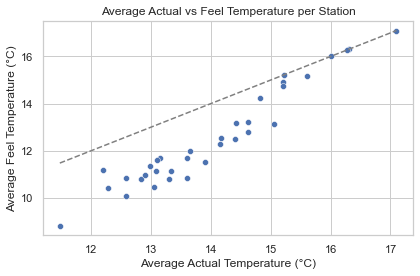

In [13]:
# Group by station and calculate daily averages
df_avg = df_merged.groupby('stationname')[['temperature', 'feeltemperature']].mean().reset_index()

# Plot
sns.set(style="whitegrid")
sns.scatterplot(data=df_avg, x='temperature', y='feeltemperature')

# Reference line y = x
plt.plot([df_avg['temperature'].min(), df_avg['temperature'].max()],
         [df_avg['temperature'].min(), df_avg['temperature'].max()],
         color='gray', linestyle='--')

plt.title("Average Actual vs Feel Temperature per Station")
plt.xlabel("Average Actual Temperature (°C)")
plt.ylabel("Average Feel Temperature (°C)")
plt.tight_layout()
plt.show()


In this plot you can see the feel temperature vs the actual. Every station is a datapoint (averaged), as you can see the feel
temperature is usually lower than the actual temperature

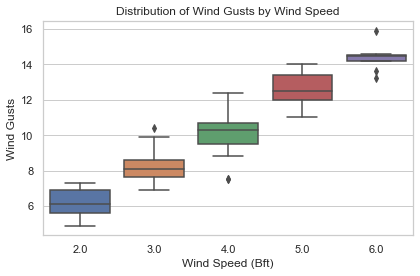

In [20]:
sns.boxplot(data=df_merged, x='windspeedBft', y='windgusts')
plt.title("Distribution of Wind Gusts by Wind Speed")
plt.xlabel("Wind Speed (Bft)")
plt.ylabel("Wind Gusts")
plt.tight_layout()
plt.show()

By visualizing the gusts within each category, we can observe how much variation exists in gust strength at different steady wind speeds. As expected, wind gusts tend to increase as the Beaufort wind speed category increases. Additionally, the spread of gusts in each category reflects how stable or turbulent the wind conditions are at that level.

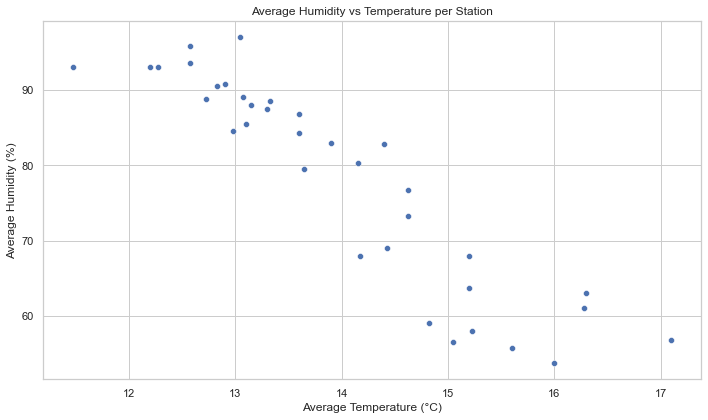

In [15]:
# Group by station and compute average temperature and humidity
df_avg = df_merged.groupby('stationname').agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

# Plot station-level averages
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_avg, x='temperature', y='humidity')

plt.title("Average Humidity vs Temperature per Station")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Average Humidity (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


This shows the average humidity vs the average temperature across all measurements in the dataset, per station. The general downward slope suggests an inverse relationship between temperature and humidity. 

To investigate whether or not stations' location has anything to do with the temperature/humidity we can group these stations based on their coordinates and compare:

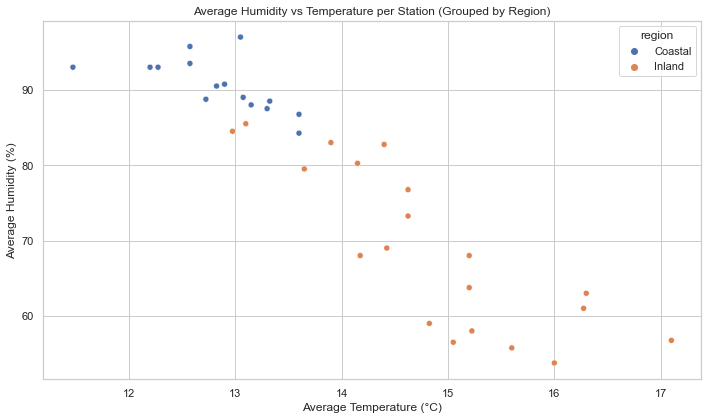

In [16]:
# Define coastal region as longitude < 5.0 (for the Netherlands)
df_stations['region'] = df_stations['lon'].apply(lambda x: 'Coastal' if x < 5.0 else 'Inland')
df_avg = df_merged.groupby('stationid').agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

# Add station names and coordinates
df_avg = df_avg.merge(df_stations[['stationid', 'stationname', 'lon']], on='stationid')
df_avg['region'] = df_avg['lon'].apply(lambda x: 'Coastal' if x < 5.0 else 'Inland')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_avg, x='temperature', y='humidity', hue='region')

plt.title("Average Humidity vs Temperature per Station (Grouped by Region)")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Average Humidity (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


As you can see, coastal stations have a higher humidity and lower temperature on average.

Furthermore we can compare wind gusts vs humidity and temperature

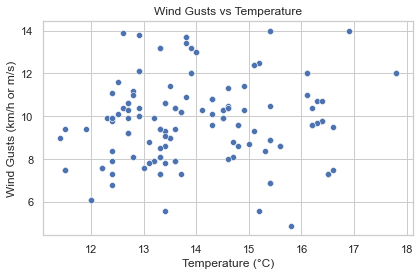

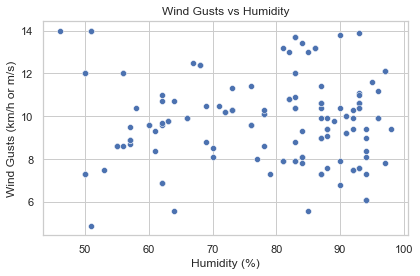

In [17]:
sns.set(style="whitegrid")

# Scatterplot with optional regression line
sns.scatterplot(data=df_merged, x='temperature', y='windgusts')

# Optional: Add regression line (comment out if not meaningful)
# sns.regplot(data=df_merged, x='temperature', y='windgusts', scatter=False, color='red', ci=None)

plt.title("Wind Gusts vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Gusts (km/h or m/s)")
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")

# Scatterplot of humidity vs windgusts
sns.scatterplot(data=df_merged, x='humidity', y='windgusts')

# Optional: Add regression line
# sns.regplot(data=df_merged, x='humidity', y='windgusts', scatter=False, color='red', ci=None)

plt.title("Wind Gusts vs Humidity")
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Gusts (km/h or m/s)")
plt.tight_layout()
plt.show()


As you can see there is no clear (visual) correlation between the variables. You can also check this by checking the correlation mathematically

In [18]:
print(df_merged[['humidity', 'windgusts']].corr())
print(df_merged[['temperature', 'windgusts']].corr())

           humidity  windgusts
humidity   1.000000  -0.051479
windgusts -0.051479   1.000000
             temperature  windgusts
temperature     1.000000   0.162219
windgusts       0.162219   1.000000


Shows a very weak/no correlation, as was expected when looking at the graphs

N.B. Obviously this is a tiny dataset and no real conclusions can be drawn either way, but nevertheless